# Análisis Exploratorio de Datos: Velocidad Media de Internet por Provincia

**Autor:** Argenis Bolivar

## Introducción

En este documento, se realiza un Análisis Exploratorio de Datos (EDA) utilizando información de la velocidad media de internet en las provincias de Argentina. Este estudio tiene como objetivo identificar patrones, tendencias temporales y variaciones geográficas, así como relacionar esta variable con otros factores relevantes como el uso de tecnologías de conexión.

El EDA permitirá:
- Evaluar la calidad y estructura de los datos.
- Describir y visualizar la distribución de la velocidad media.
- Explorar posibles correlaciones y tendencias relevantes.

## Importar Librerias

In [704]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import geopandas as gpd
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import numpy as np


## Carga de Datos

In [705]:
df_vel_media_provincia = pd.read_csv('./Datasets/vel_media_provincia.csv')
df_penetracion_hogar= pd.read_csv('./Datasets/penetracion_hogar.csv')
df_penetracion_poblac= pd.read_csv('./Datasets/penetracion_poblac.csv')
df_tecnologia_provincia= pd.read_csv('./Datasets/tecnologia_provincia.csv')

In [706]:
df_vel_media_provincia['Fecha'] = pd.to_datetime(df_vel_media_provincia['Fecha'])
df_penetracion_hogar['Fecha'] = pd.to_datetime(df_penetracion_hogar['Fecha'])
df_penetracion_poblac['Fecha'] = pd.to_datetime(df_penetracion_poblac['Fecha'])
df_tecnologia_provincia['Fecha'] = pd.to_datetime(df_tecnologia_provincia['Fecha'])

## Plan de Analisis

1. Patrones y tendencias temporales: Analizar cómo ha cambiado la velocidad media de internet a través del tiempo, tanto a nivel nacional como por provincia.

2. Variaciones geográficas:Explorar las diferencias en la velocidad media entre provincias y visualizarlo en un mapa.

3. Relación con tecnologías de conexión:Identificar cómo las tecnologías (ADSL, Fibra Óptica, etc.) están asociadas con la velocidad media en cada provincia.


## 1. Patrones y tendencias temporales: Analizar cómo ha cambiado la velocidad media de internet a través del tiempo, tanto a nivel nacional como por provincia.


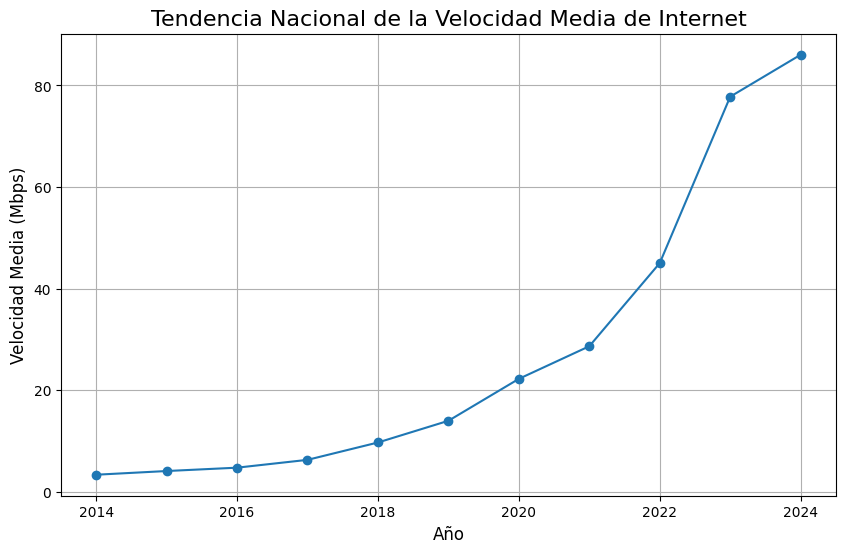

In [707]:
# 1.a) Analizar tendencias temporales de la velocidad media de internet a nivel nacional

# Agrupar los datos por año y calcular la media nacional
velocidad_anual = df_vel_media_provincia.copy()
velocidad_anual["Fecha"] = pd.to_datetime(velocidad_anual["Fecha"])
velocidad_anual["Año"] = velocidad_anual["Fecha"].dt.year
velocidad_anual["Velocidad Media (Mbps)"] = velocidad_anual["Mbps (Media de bajada)"]

tendencias_nacionales = velocidad_anual.groupby("Año")["Mbps (Media de bajada)"].mean().reset_index()

# Visualizar la tendencia con un gráfico de línea

plt.figure(figsize=(10, 6))
plt.plot(
    tendencias_nacionales["Año"],
    tendencias_nacionales["Mbps (Media de bajada)"],
    marker="o",
    linestyle="-",
)
plt.title("Tendencia Nacional de la Velocidad Media de Internet", fontsize=16)
plt.xlabel("Año", fontsize=12)
plt.ylabel("Velocidad Media (Mbps)", fontsize=12)
plt.grid(True)
plt.show()

In [ ]:
print(tendencias_nacionales)
#Obsevamos una tabla del promedio de Velocidad de Bajada por Año

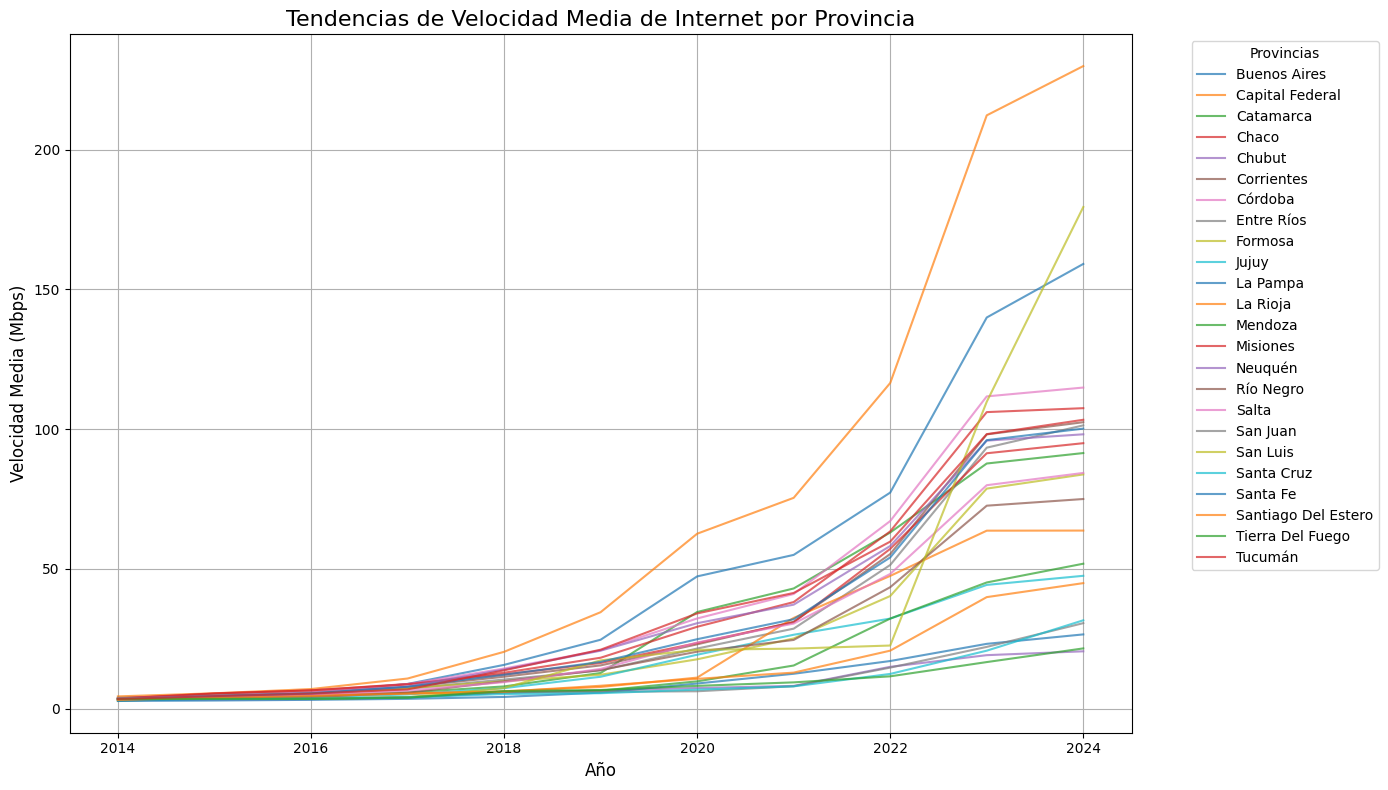

In [709]:
        #1.b) Agrupar los datos por año y provincia para calcular la velocidad media por provincia

tendencias_provincias = velocidad_anual.groupby(["Año", "Provincia"])["Mbps (Media de bajada)"].mean().reset_index()

# Crear un gráfico de líneas para mostrar las tendencias por provincia
plt.figure(figsize=(14, 8))

# Iterar por cada provincia y trazar su tendencia
provincias = tendencias_provincias["Provincia"].unique()
for provincia in provincias:
    datos_provincia = tendencias_provincias[tendencias_provincias["Provincia"] == provincia]
    plt.plot(
        datos_provincia["Año"],
        datos_provincia["Mbps (Media de bajada)"],
        label=provincia,
        alpha=0.7,
    )

plt.title("Tendencias de Velocidad Media de Internet por Provincia", fontsize=16)
plt.xlabel("Año", fontsize=12)
plt.ylabel("Velocidad Media (Mbps)", fontsize=12)
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), title="Provincias", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


El gráfico muestra las tendencias de velocidad media de internet por provincia a lo largo de los años. Cada línea representa una provincia, lo que permite observar diferencias en la evolución de las velocidades.

## Observaciones:
Las provincias tienen patrones de crecimiento diferenciados.
Algunas han experimentado incrementos más significativos en comparación con otras. 


In [710]:
vel_media_provincial = velocidad_anual.pivot(
    index="Fecha", columns="Provincia", values="Mbps (Media de bajada)")

In [ ]:
# Calcular el crecimiento porcentual de la velocidad media para cada provincia

# Se reestructura el dataframe para ordenar en funcion de la fecha y como columnas enten las Provincias
vel_media_provincial = velocidad_anual.pivot(
    index="Fecha", columns="Provincia", values="Mbps (Media de bajada)")


vel_media_crecimiento = vel_media_provincial.pct_change().mean() * 100

# Ordenar provincias por mayor crecimiento promedio
vel_media_crecimiento_sorted = vel_media_crecimiento.sort_values(ascending=False)

# Visualizar el crecimiento porcentual promedio
plt.figure(figsize=(10, 6))
vel_media_crecimiento_sorted.plot(kind="bar", edgecolor='black')
plt.title("Crecimiento Promedio de Velocidad Media por Provincia (%)", fontsize=14)
plt.xlabel("Provincia", fontsize=12)
plt.ylabel("Crecimiento Promedio (%)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


El gráfico muestra el crecimiento promedio porcentual de la velocidad media de internet por provincia. Este análisis destaca cuáles provincias han tenido mayores avances en velocidad promedio durante el período analizado.


## 2. Relación de Velocidad Promedio de Bajada con Tecnologías de Conexión
- Comparación de velocidades medias donde predomina una tecnología específica.
- Estudiar cómo el uso de cada tecnología ha cambiado en el tiempo y si estas variaciones afectan la velocidad media.


2.1. Comparación de velocidades medias donde predomina una tecnología específica.

In [ ]:
# Analizar la influencia de las tecnologías en la velocidad media

# Integrar los datos de tecnologías con velocidad media
data = pd.merge(df_tecnologia_provincia, df_vel_media_provincia, on=["Provincia", "Fecha"], how="inner")

# Calcular la proporción de cada tecnología en el total por provincia
tecnologias = ["ADSL", "Cablemodem", "Fibra óptica", "Wireless", "Otros"]
for tecnologia in tecnologias:
    data[f"prop_{tecnologia}"] = data[tecnologia] / data["Total"]

# Análisis por tecnología predominante
data["Tecnologia_Predominante"] = data[tecnologias].idxmax(axis=1)

# Promedio de velocidad media por tecnología predominante
vel_media_tecnologia = data.groupby("Tecnologia_Predominante")["Mbps (Media de bajada)"].mean().sort_values(ascending=False)

# Cambios en el tiempo: evolución del uso de tecnologías
tend_tecnol = data.groupby("Fecha")[tecnologias].sum()
tendencia = tend_tecnol.div(tend_tecnol.sum(axis=1), axis=0)

vel_media_tecnologia, tendencia.tail()  # Mostrar resumen del análisis


Este ultimo codigo analiza la evolución del uso de tecnologías de conexión en el tiempo, calculando cómo cambia la proporción de cada tecnología en el total de conexiones para cada fecha.

In [ ]:
# Visualización de la velocidad media por tecnología predominante
plt.figure(figsize=(10, 6))
vel_media_tecnologia.sort_values().plot(kind='barh', color='skyblue', edgecolor='black')
plt.title("Velocidad Media por Tecnología Predominante")
plt.xlabel("Velocidad Media (Mbps)")
plt.ylabel("Tecnología Predominante")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

Resultados del Análisis de Influencia de las Tecnologías:


1. Velocidad Media por Tecnología Predominante:

- Fibra Óptica tiene la mayor velocidad media de descarga con 63.23 Mbps, confirmando su capacidad superior en comparación con otras tecnologías.
- Wireless y Cablemodem siguen con velocidades medias de 43.92 Mbps y 37.05 Mbps, respectivamente.
- ADSL y Otros presentan velocidades significativamente más bajas, con 7.45 Mbps y 8.56 Mbps, indicando que son tecnologías menos efectivas para altas velocidades.

2. Tendencias en el Uso de Tecnologías (2023-2024):

- La proporción de conexiones por Fibra Óptica ha aumentado gradualmente, de 28.85% en enero de 2023 a 34.51% en enero de 2024, lo que sugiere una transición hacia tecnologías más avanzadas.
- Cablemodem sigue siendo la tecnología más utilizada, aunque su participación ha disminuido ligeramente de 53.39% a 51.46%.
- El uso de ADSL ha disminuido constantemente, cayendo de 10.71% a 6.66%, reflejando un abandono progresivo de esta tecnología más antigua.


Implicaciones:

1. Fibra Óptica es clave para mejorar velocidades:

    Provincias con alta penetración de Fibra Óptica disfrutan de velocidades más altas, lo que sugiere que la expansión de esta tecnología debería ser una prioridad.

2. ADSL y Wireless requieren revisión:

    Las provincias que dependen en gran medida de estas tecnologías podrían beneficiarse significativamente de un plan para actualizar su infraestructura.

3. Cablemodem mantiene su relevancia:

    Aunque no es la tecnología más avanzada, sigue siendo una opción importante para áreas donde la Fibra Óptica aún no está disponible.

2.2. Estudiar cómo el uso de cada tecnología ha cambiado en el tiempo y si estas variaciones afectan la velocidad media.

In [ ]:
# Visualización de la evolución de las proporciones de uso de tecnologías
tendencia.plot(kind="line", figsize=(12, 8), linewidth=2, marker='o', alpha=0.8)
plt.title("Evolución del Uso de Tecnologías (2023-2024)")
plt.ylabel("Proporción del Total de Conexiones")
plt.xlabel("Fecha")
plt.xticks(rotation=45)
plt.legend(title="Tecnología", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Evolución del Uso de Tecnologías:

- Fibra Óptica muestra un aumento constante en su proporción, reflejando su adopción creciente.
- Aunque Cablemodem sigue siendo la tecnología más utilizada, su proporción está disminuyendo lentamente.
- ADSL tiene una caída notable en uso, indicando su obsolescencia progresiva.

In [ ]:
# Correlación entre proporciones de tecnologías y velocidad media
correlacion_tecnologias = data[["Mbps (Media de bajada)"] + [f"prop_{tecnologia}" for tecnologia in tecnologias]].corr()

# Extraer solo las correlaciones de las proporciones de tecnologías con la velocidad media
correlacion_veloc_tecnologia = correlacion_tecnologias.loc["Mbps (Media de bajada)", [f"prop_{tecnologia}" for tecnologia in tecnologias]]

print(correlacion_veloc_tecnologia)

In [ ]:
# Visualización de la correlación entre tecnologías y velocidad media

# Crear un gráfico de barras para mostrar las correlaciones
plt.figure(figsize=(10, 6))
correlacion_veloc_tecnologia.sort_values().plot(kind='barh', color='skyblue', edgecolor='black')
plt.title("Correlación entre Tecnologías y Velocidad Media")
plt.xlabel("Coeficiente de Correlación")
plt.ylabel("Tecnologías")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


1. Correlación entre Tecnologías y Velocidad Media:

- Fibra Óptica: Correlación positiva fuerte (0.641), indicando que a mayor proporción de conexiones de fibra óptica en una provincia, mayor es la velocidad media.
- Cablemodem: Correlación positiva moderada (0.303), mostrando que esta tecnología también contribuye a velocidades más altas, aunque menos que la fibra óptica.
- Wireless: Correlación débil positiva (0.095), sugiriendo que su impacto en las velocidades es limitado, posiblemente debido a restricciones tecnológicas o de infraestructura.
- ADSL: Correlación negativa significativa (-0.587), indicando que las provincias con mayor dependencia de ADSL tienen velocidades más bajas en general, lo que refuerza su estatus como una tecnología obsoleta.

2. Implicaciones:
- Fibra Óptica es clave para altas velocidades: Provincias que prioricen la expansión de esta tecnología pueden experimentar mejoras significativas en la velocidad.
- Cablemodem sigue siendo relevante: Aunque no tan efectiva como la fibra óptica, sigue siendo una tecnología viable para aumentar las velocidades.
- ADSL requiere atención urgente:Provincias con alta dependencia de ADSL están rezagadas en términos de velocidad, y deberían priorizar la transición a tecnologías más avanzadas.

## 3. Penetracion y Tecnologias
Explorar las diferencias en la velocidad media y la penetración de accesos (penetracion_poblac y penetracion_hogar) entre provincias.
Crear visualizaciones geográficas (mapas) para identificar patrones espaciales. Por ejemplo:
Mapa de calor para la velocidad media por provincia.
Mapa de penetración de accesos por población y hogares.


3.1. Explorar las diferencias en la velocidad media y la penetración de accesos (penetracion_poblac y penetracion_hogar) entre provincias.
Crear visualizaciones geográficas (mapas) para identificar patrones espaciales.

In [717]:
# Unificar dataset: Combimnar los datos en un solo Dataframe para analisis cruzados
merged_data = pd.merge(df_penetracion_hogar, df_penetracion_poblac, on=["Provincia", "Fecha"], how="inner")
merged_data = pd.merge(merged_data, df_tecnologia_provincia, on=["Provincia", "Fecha"], how="inner")
merged_data = pd.merge(merged_data, df_vel_media_provincia, on=["Provincia", "Fecha"], how="inner")

# Renombrar columnas para su facil entendimeinto
merged_data.rename(columns={
    "Accesos por cada 100 hogares": "Penetración_hogar",
    "Accesos por cada 100 hab": "Penetración_población",
    "Mbps (Media de bajada)": "Velocidad_media"
}, inplace=True)

# merged_data.drop(columns= ["Unnamed: 0_x", "Unnamed: 0_y"], inplace=True)

In [ ]:
# Visualizacion Inicial: Comparar velocidad media y penetracion entre provincias

import seaborn as sns

# Scatter Plot: Velocidad Media vs. Penetración por Población
plt.figure(figsize=(16, 6))
sns.scatterplot(
    data=merged_data, 
    x='Penetración_población', 
    y='Velocidad_media', 
    hue='Provincia', 
    marker='x',  
    s=100)
plt.title('Relación entre Velocidad Media y Penetración por Población', fontsize=14)
plt.xlabel('Penetración por Población (%)', fontsize=12)
plt.ylabel('Velocidad Media (Mbps)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Provincia')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Scatter Plot: Velocidad Media vs. Penetración por Hogares
plt.figure(figsize=(16, 6))
sns.scatterplot(
    data=merged_data, 
    x='Penetración_hogar', 
    y='Velocidad_media', 
    hue='Provincia', 
    marker='x',  
    s=100)
plt.title('Relación entre Velocidad Media y Penetración por Hogares', fontsize=14)
plt.xlabel('Penetración por Hogares (%)', fontsize=12)
plt.ylabel('Velocidad Media (Mbps)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Provincia')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


OBSERVACIONES
- Puedes observar si existe una tendencia positiva entre la penetración y la velocidad media.
- Las provincias con patrones destacados están identificadas por colores distintos.

Vamos a ahondar un poco en la correlacion, relizando un Analisis Estadisticos con Correlaciones y Regresiones


In [ ]:
# Analisis Estadistico: Correlaciones y Regresiones:
 
# Correlacion entre Velocidad Media de descarga y Penetracion Poblacional, y con Penetracion por Hogar
correlation_poblacional, p_value_poblacional = pearsonr(merged_data['Penetración_población'], merged_data['Velocidad_media'])
correlation_hogar, p_value_hogar = pearsonr(merged_data['Penetración_hogar'], merged_data['Velocidad_media'])

# Analisis de la Regresion: Penetración por Poblacional
X_poblacion = merged_data[['Penetración_población']]
y_poblacion = merged_data['Velocidad_media']
reg_poblacion = LinearRegression().fit(X_poblacion, y_poblacion)

#  Analisis de la Regresion: Penetración por Hogares
X_hogar = merged_data[['Penetración_hogar']]
y_hogar = merged_data['Velocidad_media']
reg_hogar = LinearRegression().fit(X_hogar, y_hogar)

# Resultados
resultados = {
    "Penetración por Población": {
        "Correlación de Pearson": correlation_poblacional,
        "P-valor": p_value_poblacional,
        "Pendiente (slope)": reg_poblacion.coef_[0],
        "Intercepto": reg_poblacion.intercept_,
        "R-cuadrado": reg_poblacion.score(X_poblacion, y_poblacion),
    },
    "Penetración por Hogares": {
        "Correlación de Pearson": correlation_hogar,
        "P-valor": p_value_hogar,
        "Pendiente (slope)": reg_hogar.coef_[0],
        "Intercepto": reg_hogar.intercept_,
        "R-cuadrado": reg_hogar.score(X_hogar, y_hogar),
    }
}

resultados

Análisis Profundo de las Relaciones


1. Relación entre Velocidad Media y Penetración por Población
- Correlación de Pearson: 0.42. Relación positiva moderada, indicando que un mayor acceso en la población generalmente se asocia con velocidades más altas.
- P-valor: 2.50e-43. La correlación es estadísticamente significativa.
- Pendiente (slope): 1.44. Por cada 1% de aumento en la penetración por población, la velocidad media aumenta en 1.44 Mbps, en promedio.
- Intercepto: 0.77. Representa la velocidad estimada cuando la penetración es 0% (valor teórico).
- R-cuadrado: 0.176. El 17.6% de la variabilidad en la velocidad media puede explicarse por la penetración en población.

2. Relación entre Velocidad Media y Penetración por Hogares
- Correlación de Pearson: 0.46. Relación positiva moderada, más fuerte que la relación con la penetración por población.
- P-valor: 5.47e-52. También estadísticamente significativa.
- Pendiente (slope): 0.60. Por cada 1% de aumento en la penetración por hogares, la velocidad media aumenta en 0.60 Mbps.
- Intercepto: -8.19. Velocidad teórica cuando no hay penetración (indicador del límite del modelo lineal).
- R-cuadrado: 0.209. El 20.9% de la variabilidad en la velocidad media puede explicarse por la penetración en hogares.

Conclusiones:

Existe una relación positiva moderada entre la penetración y la velocidad media, siendo más fuerte con la penetración por hogares.
Las variables de penetración explican parcialmente las diferencias en velocidades, pero otros factores (como la tecnología predominante) también influyen

## 4. Análisis de Tendencia

- Identificar provincias con crecimiento destacado en velocidades o penetración y analizar las posibles causas.
- Evaluar la desigualdad en el acceso a internet, basándose en las diferencias geográficas y de tecnologías


1. Identificar el crecimiento destacado

Calcular la tasa de cambio porcentual de la velocidad media y las tasas de penetración (población y hogares) por provincia a lo largo del tiempo.
Detectar las provincias con el mayor crecimiento en estas métricas.

In [720]:
df_vel_media_provincia = df_vel_media_provincia.sort_values(by=['Provincia', 'Fecha'])
df_penetracion_hogar = df_penetracion_hogar.sort_values(by=['Provincia', 'Fecha'])
df_penetracion_poblac = df_penetracion_poblac.sort_values(by=['Provincia', 'Fecha'])


# Ajustar nombre de columnas para calculos de tasa de crecimiento de penetracion
df_vel_media_provincia['Tasa_de_crecimiento_vel_media'] = df_vel_media_provincia.groupby('Provincia')['Mbps (Media de bajada)'].pct_change() * 100
df_penetracion_hogar['Tasa_de_crecimiento_penetracion_hogar'] = df_penetracion_hogar.groupby('Provincia')['Accesos por cada 100 hogares'].pct_change() * 100
df_penetracion_poblac['Tasa_de_crecimiento_penetracion_poblacion'] = df_penetracion_poblac.groupby('Provincia')['Accesos por cada 100 hab'].pct_change() * 100

# Promediar tasa de crecimiento para ver provincias con mayor tasa de crecimiento
crecimiento_vel_media = df_vel_media_provincia.groupby('Provincia')['Tasa_de_crecimiento_vel_media'].mean().reset_index()
crecieminto_penetracion_hogar = df_penetracion_hogar.groupby('Provincia')['Tasa_de_crecimiento_penetracion_hogar'].mean().reset_index()
crecimiento_penetracion_poblac = df_penetracion_poblac.groupby('Provincia')['Tasa_de_crecimiento_penetracion_poblacion'].mean().reset_index()

# Union de la data
resumen_crecimiento = crecimiento_vel_media.merge(crecieminto_penetracion_hogar, on='Provincia').merge(crecimiento_penetracion_poblac, on='Provincia')


In [ ]:
top_vel_media = resumen_crecimiento.nlargest(5, 'Tasa_de_crecimiento_vel_media')[['Provincia', 'Tasa_de_crecimiento_vel_media']]
top_penetracion_hogar = resumen_crecimiento.nlargest(5, 'Tasa_de_crecimiento_penetracion_hogar')[['Provincia', 'Tasa_de_crecimiento_penetracion_hogar']]
top_penetracion_poblac = resumen_crecimiento.nlargest(5, 'Tasa_de_crecimiento_penetracion_poblacion')[['Provincia', 'Tasa_de_crecimiento_penetracion_poblacion']]

top_crecimiento = {
    "Top_crecimeinto_velocidad (Mbps)": top_vel_media,
    "Top_crecimiento_penetracion_hogar (%)": top_penetracion_hogar,
    "Top_crecimiento_penetracion_poblacion (%)": top_penetracion_poblac,
}

top_crecimiento

In [ ]:
# 1. Tendencia Temporal de Crecimiento por Provincia (Línea para Velocidad)
top_provinces = top_vel_media['Provincia'].tolist()
vel_media_top =df_vel_media_provincia[df_vel_media_provincia['Provincia'].isin(top_provinces)]

plt.figure(figsize=(12, 6))
for province in top_provinces:
    province_data = vel_media_top[vel_media_top['Provincia'] == province]
    plt.plot(province_data['Fecha'], province_data['Mbps (Media de bajada)'], label=province)

plt.title("Tendencia Temporal de Velocidad Media en Provincias con Mayor Crecimiento")
plt.xlabel("Fecha")
plt.ylabel("Velocidad Media (Mbps)")
plt.legend(title="Provincias")
plt.grid(True)
plt.show()

1. Tendencia Temporal de Velocidad Media

    - Las provincias con mayor crecimiento muestran un aumento sostenido en la velocidad media de internet, aunque con variaciones.
    - Algunas provincias destacan con incrementos más abruptos en ciertos períodos, lo que podría estar relacionado con inversiones en infraestructura tecnológica o la adopción de nuevas tecnologías.

In [ ]:
# 2. Comparación de Crecimiento Promedio por Provincia (Barras)
growth_summary_top = resumen_crecimiento[resumen_crecimiento['Provincia'].isin(top_provinces)]

growth_summary_top.plot(
    x='Provincia',
    kind='bar',
    figsize=(12, 6),
    title='Comparación de Crecimiento Promedio por Provincia',
    ylabel='Tasa de Crecimiento (%)',
    xlabel='Provincia',
    legend=True,
    grid=True
)
plt.show()

2. Comparación de Crecimiento Promedio por Provincia

    - Las provincias con mayor crecimiento en velocidad no siempre coinciden con las de mayor crecimiento en penetración por hogares o población.
    - Esto sugiere que, en algunos casos, el avance tecnológico (como la mejora en velocidades) no está acompañado por una ampliación significativa del acceso al internet, lo que podría indicar desigualdad en el acceso.

In [ ]:
# 3. Relación entre la taza de crecimeinto de Velocidad y  de Penetración (Dispersión)
plt.figure(figsize=(8, 6))
plt.scatter(resumen_crecimiento['Tasa_de_crecimiento_penetracion_hogar'], resumen_crecimiento['Tasa_de_crecimiento_vel_media'], alpha=0.7, c='blue', label='Hogar vs Velocidad')
plt.scatter(resumen_crecimiento['Tasa_de_crecimiento_penetracion_poblacion'], resumen_crecimiento['Tasa_de_crecimiento_vel_media'], alpha=0.7, c='orange', label='Población vs Velocidad')
plt.title("Relación entre Penetración y Velocidad Media")
plt.xlabel("Tasa de Crecimiento en Penetración (%)")
plt.ylabel("Tasa de Crecimiento en Velocidad Media (%)")
plt.axhline(0, color='grey', linewidth=0.8, linestyle='--')
plt.axvline(0, color='grey', linewidth=0.8, linestyle='--')
plt.legend()
plt.grid(True)
plt.show()


3. Relación entre Penetración y Velocidad Media

    - Existe una correlación moderada entre la penetración por hogares/población y la velocidad media, lo que sugiere que las mejoras en acceso generalmente vienen acompañadas de una mejora en la calidad del servicio.
    - Sin embargo, hay puntos fuera de la tendencia principal, indicando provincias donde la velocidad mejoró sin un crecimiento proporcional en la penetración o viceversa.

In [ ]:
# 4. Distribución de Crecimientos (Boxplot)
plt.figure(figsize=(10, 6))
plt.boxplot(
    [resumen_crecimiento['Tasa_de_crecimiento_vel_media'], resumen_crecimiento['Tasa_de_crecimiento_penetracion_hogar'], resumen_crecimiento['Tasa_de_crecimiento_penetracion_poblacion']],
    labels=['Velocidad', 'Penetración Hogar', 'Penetración Población']
)
plt.title("Distribución de Crecimientos por Métrica")
plt.ylabel("Tasa de Crecimiento (%)")
plt.grid(True)
plt.show()


4. Distribución de Crecimientos por Métrica

    - La velocidad media tiene una mayor dispersión en las tasas de crecimiento comparada con la penetración, indicando que el crecimiento tecnológico no ha sido uniforme.
    - Las tasas de crecimiento en penetración por hogares y población muestran distribuciones más compactas, lo que podría sugerir políticas o inversiones más homogéneas en estas áreas.

Conclusiones Generales

- Hay desigualdades significativas en el acceso y la mejora tecnológica entre provincias, con algunas avanzando mucho más rápido en velocidad que en penetración.
- Las mejoras en velocidad parecen estar más relacionadas con la adopción de tecnologías avanzadas, mientras que las mejoras en penetración podrían depender más de factores sociales o económicos.
- Algunas provincias han logrado un crecimiento destacado, pero identificar las causas exactas requerirá un análisis más profundo de las tecnologías predominantes en esas regiones.

## 5. KPI

KPI Propuesto: Gráfico de barras que muestra el incremento proyectado del acceso a internet (8%) para el proximo anno para cada provincia.

Se generara data aleatoria para la penetracion por hogar  para el anno 2024. Esta sera comparada con la propuesta estimada (8% al para el ultimo trimestre 2024)

In [3]:
# Tomar los datos de penetracion hogar del ultimo trimestre 2023 y primero 2024
penetracion_hogar_T4_2023 = df_penetracion_hogar[(df_penetracion_hogar['Fecha'].dt.year == 2023)&(df_penetracion_hogar['Fecha'].dt.month == 10)].copy()
penetracion_hogar_T1_2024 = df_penetracion_hogar[(df_penetracion_hogar['Fecha'].dt.year == 2024)&(df_penetracion_hogar['Fecha'].dt.month == 1)].copy()

#Generacion de Data
Trimestres_2024 = ["2024-01-01", "2024-04-01", "2024-07-01", "2024-10-01"]
crecimiento_estimado = [2, 4, 6, 8]

datos_proyectados = []
for index, row in penetracion_hogar_T4_2023.iterrows():
    penetracion_hogar_2023 = row['Accesos por cada 100 hogares']
    for i, trimestre in enumerate(Trimestres_2024):
        penetracion_hogar_estimada = penetracion_hogar_2023 * (1 + crecimiento_estimado[i] / 100)
        penetracion_hogar_simulada = penetracion_hogar_estimada * (1 + np.random.uniform(-0.08, 0.08))  # Random variation of +/- 8%
        datos_proyectados.append({
            'Provincia': row['Provincia'],
            'Fecha': pd.to_datetime(trimestre),
            'Estimado': penetracion_hogar_estimada,
            'Simulado': penetracion_hogar_simulada
        })

penetracion_hogar_proyectado = pd.DataFrame(datos_proyectados)
penetracion_hogar_proyectado = penetracion_hogar_proyectado.sort_values(by=['Provincia', 'Fecha'], ascending=[True, False]).reset_index(drop=True)

penetracion_hogar_estimado = penetracion_hogar_proyectado[['Provincia', 'Fecha', 'Estimado']].copy()
penetracion_hogar_simulado = penetracion_hogar_proyectado[['Provincia', 'Fecha', 'Simulado']].copy()

penetracion_hogar_T4_2023.rename(columns={'Accesos por cada 100 hogares': 'Estimado'}, inplace=True)
penetracion_hogar_T4_2023 = penetracion_hogar_T4_2023.sort_values(by=['Provincia', 'Fecha'], ascending=[True, False]).reset_index(drop=True)

correccion = penetracion_hogar_simulado.copy()
correccion.loc[correccion['Fecha'] == '2024-01-01', 'Simulado'] = correccion.loc[correccion['Fecha'] == '2024-01-01', 'Provincia'].map(penetracion_hogar_T1_2024.set_index('Provincia')['Accesos por cada 100 hogares'])
penetracion_hogar_simulado = correccion


penetracion_hogar_proyectado['KPI'] = pd.DataFrame({
    'KPI': ((penetracion_hogar_simulado['Simulado'] - penetracion_hogar_estimado['Estimado']) / 
            penetracion_hogar_estimado['Estimado']) * 100
})

kpi_mean = penetracion_hogar_proyectado.groupby('Fecha')['KPI'].mean().reset_index()

NameError: name 'df_penetracion_hogar' is not defined

In [ ]:


plt.figure(figsize=(12, 6))
plt.plot(kpi_mean['Fecha'], kpi_mean['KPI'], marker='o', label='KPI Promedio', color='green')
plt.title("Comportamiento del KPI en el Tiempo")
plt.xlabel("Fecha")
plt.ylabel("KPI (%)")
plt.axhline(2, color='red', linestyle='--', label='Meta del KPI (2%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Grafica del KPI



# Calculo de la media por Trimestre
penetracion_hogar_estimado_mean = penetracion_hogar_estimado.groupby('Fecha')['Estimado'].mean().reset_index()
penetracion_hogar_simulado_mean = penetracion_hogar_simulado.groupby('Fecha')['Simulado'].mean().reset_index()


penetracion_hogar_simulado_mean.rename(columns={'Simulado': 'Real'}, inplace=True)
# Grafica

plt.figure(figsize=(12, 6))
plt.plot(penetracion_hogar_estimado_mean['Fecha'], penetracion_hogar_estimado_mean['Estimado'], marker='o', label='Estimado', color='blue')
plt.plot(penetracion_hogar_simulado_mean['Fecha'], penetracion_hogar_simulado_mean['Real'], marker='x', label='Real', color='orange')
plt.title("Tendencia de Estimados y Real de Penetración por Hogar")
plt.xlabel("Fecha")
plt.ylabel("Accesos por cada 100 Hogares (Promedio Nacional)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Conclusiones 

1. Crecimiento Sostenido:

    El análisis muestra un incremento en la penetración de internet en los hogares desde el último trimestre de 2023 hasta el último trimestre de 2024.
    
    Diferencia porcentual estimada: Un crecimiento mayor del 2% refleja que se está logrando un avance progresivo según las metas planteadas.
    
    Diferencia porcentual real: Un incremento del 2.3% en los datos reales confirma que la penetración de internet sigue una tendencia positiva.
    
    Esto indica que las políticas, inversiones en infraestructura y esfuerzos para expandir el servicio han sido efectivos. La evolución trimestre a trimestre destaca la consistencia en el crecimiento, sin caídas significativas.
    La diferencia porcentual real puede ser útil para ajustar estrategias en áreas que no alcanzaron el crecimiento esperado.

5.2. KPI Propuesto: Incremento proyectado de la Velocidad del 10% Trimestral para el proximo anno para las provincias con menos Velocidad Media de Descarga

Se generara data aleatoria para la Velocidad Medias de Descarga para el anno 2024. Esta sera comparada con la propuesta estimada (40% para el ultimo trimestre 2024)

In [794]:
ultimo_trimestre_2023 = df_vel_media_provincia[(df_vel_media_provincia['Fecha'].dt.year == 2023) &
                                            (df_vel_media_provincia['Fecha'].dt.month >= 10)]

# Ordenar por velocidad promedio en orden ascendente y tomar las dos provincias con menor velocidad
provincias_menor_velocidad = ultimo_trimestre_2023.nsmallest(2, 'Mbps (Media de bajada)')


In [796]:
#Generacion de Data
Trimestres_2024 = ["2024-01-01", "2024-04-01", "2024-07-01", "2024-10-01"]
crecimiento_estimado = [10, 20 , 30, 40]

datos_proyectados = []
for index, row in provincias_menor_velocidad.iterrows():
    velocida_media_2023 = row['Mbps (Media de bajada)']
    for i, trimestre in enumerate(Trimestres_2024):
        velocidad_media_estimada = velocida_media_2023 * (1 + crecimiento_estimado[i] / 100)
        velocidad_media_simulada = velocidad_media_estimada * (1 + np.random.uniform(-0.10, 0.10))  # Random variation of +/- 10%
        datos_proyectados.append({
            'Provincia': row['Provincia'],
            'Fecha': pd.to_datetime(trimestre),
            'Estimado': velocidad_media_estimada,
            'Simulado': velocidad_media_simulada
             })
        

velocidad_media_proyectado = pd.DataFrame(datos_proyectados)

velocidad_media_estimado = penetracion_hogar_proyectado[['Provincia', 'Fecha', 'Estimado']].copy()
velocidad_media_simulado = penetracion_hogar_proyectado[['Provincia', 'Fecha', 'Simulado']].copy()


velocidad_media_proyectado['KPI'] = pd.DataFrame({
    'KPI': ((velocidad_media_simulado['Simulado'] - velocidad_media_estimado['Estimado']) / 
            velocidad_media_estimado['Estimado']) * 100
})


kpi_mean_provincia = velocidad_media_proyectado.groupby(['Provincia', 'Fecha'])['KPI'].mean().reset_index()

In [ ]:
# Plotting the KPI trend for each province
plt.figure(figsize=(12, 6))

for provincia in kpi_mean_provincia['Provincia'].unique():
    provincia_data = kpi_mean_provincia[kpi_mean_provincia['Provincia'] == provincia]
    plt.plot(provincia_data['Fecha'], provincia_data['KPI'], marker='o', label=f'Provincia {provincia}')

plt.title("Tendencia del KPI por Provincia")
plt.xlabel("Fecha")
plt.ylabel("KPI (%)")
plt.axhline(0, color='red', linestyle='--', label='Referencia (0%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Graficar tendencias para cada provincia por separado
provincias = velocidad_media_proyectado['Provincia'].unique()

for provincia in provincias:
    provincia_data = velocidad_media_proyectado[velocidad_media_proyectado['Provincia'] == provincia]
    estimado_mean = provincia_data.groupby('Fecha')['Estimado'].mean().reset_index()
    simulado_mean = provincia_data.groupby('Fecha')['Simulado'].mean().reset_index()
    
    plt.figure(figsize=(12, 6))
    plt.plot(estimado_mean['Fecha'], estimado_mean['Estimado'], marker='o', label='Estimado', color='blue')
    plt.plot(simulado_mean['Fecha'], simulado_mean['Simulado'], marker='x', label='Real', color='orange')
    plt.title(f"Tendencia de Velocidad Media Estimada y Real por Trimestre - {provincia} (Mbps)")
    plt.xlabel("Fecha")
    plt.ylabel("Velocidad Media (Mbps)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()